Простая feedforward сеть на тэгах, корреляция которых с классом по модулю >= 0.001 (что оставило 1247 тэгов) плюс ещё три ad-hoc фичи (наличие разметки, наличие кода и длина поста).

In [21]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk

In [22]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

In [3]:
train_tags = pd.read_csv('preproc_files/train_tags.csv')
test_tags = pd.read_csv('preproc_files/test_tags.csv')

In [4]:
y = train_tags['class']
X = normalize(train_tags.drop('class', axis=1))
X_test = normalize(test_tags)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=42)

На этом попробуем простую FF-сеть.

In [6]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((43200, 1250), (4800, 1250), (43200,), (4800,))

In [8]:
import tensorflow as tf

In [9]:
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [87]:
from utils import plot_train_acc, plot_train_loss

In [11]:
seed=42

In [113]:
def build_ff(in_size, dropout_rate, num_classes):
    feat_input = Input(shape=(in_size,))
    z = Dense(256, activation='relu')(feat_input)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    z = Dense(256, activation='relu')(z)
    z = BatchNormalization(trainable=True)(z)
    z = Dropout(dropout_rate)(z)
    y = Dense(num_classes, activation='softmax')(z)
    model = Model(inputs=feat_input, outputs=y)
    return model

In [114]:
in_size = 1250
dropout_rate = 0.4
batch_size = 512
epochs = 100
num_classes = 3

In [115]:
model = build_ff(in_size, dropout_rate, num_classes)

In [116]:
mc = ModelCheckpoint('checkpoints/best_ff_features.h5', monitor='val_loss', mode='auto', save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=3, min_delta=0.0001)
lr_reduction = ReduceLROnPlateau(monitor='val_acc', patience = 2, verbose=1,factor=0.4, min_lr=0.0000001)

In [117]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print(model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1250)]            0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               320256    
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0  

In [118]:
history=model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks = [mc, earlystop, lr_reduction],
          verbose=1,
          validation_data=(X_val, y_val))

Train on 43200 samples, validate on 4800 samples
Epoch 1/100
43200/43200 [==============================] - 3s 76us/sample - loss: 0.7403 - acc: 0.7060 - val_loss: 1.0964 - val_acc: 0.3429
Epoch 2/100
43200/43200 [==============================] - 1s 25us/sample - loss: 0.5086 - acc: 0.7795 - val_loss: 1.0506 - val_acc: 0.3435
Epoch 3/100
43200/43200 [==============================] - 1s 27us/sample - loss: 0.4540 - acc: 0.8035 - val_loss: 0.9409 - val_acc: 0.3994
Epoch 4/100
43200/43200 [==============================] - 1s 28us/sample - loss: 0.4306 - acc: 0.8140 - val_loss: 0.8006 - val_acc: 0.5940
Epoch 5/100
43200/43200 [==============================] - 1s 25us/sample - loss: 0.4142 - acc: 0.8217 - val_loss: 0.6496 - val_acc: 0.6985
Epoch 6/100
43200/43200 [==============================] - 1s 26us/sample - loss: 0.3955 - acc: 0.8321 - val_loss: 0.5284 - val_acc: 0.7690
Epoch 7/100
43200/43200 [==============================] - 1s 22us/sample - loss: 0.3841 - acc: 0.8342 - val_lo

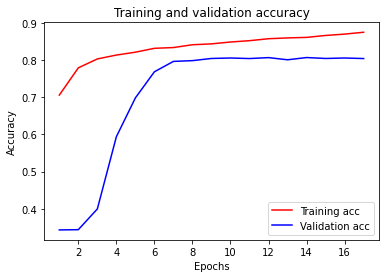

In [119]:
plot_train_acc(history)

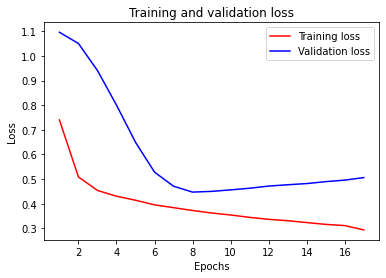

In [120]:
plot_train_loss(history)